# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import scipy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.combine import SMOTEENN


# Loading the Files

Download the csv files into the `data/` directory

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

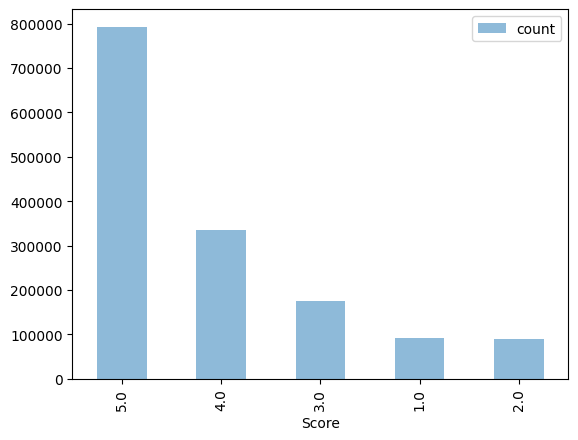


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
# Load datasets
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Visualize class distribution
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
# Precompute the average score per product once to avoid redundant computation
product_avg_scores = trainingSet.groupby('ProductId')['Score'].mean().reset_index(name='Product_Avg_Score')
print("Precomputed Product_Avg_Score preview:", product_avg_scores.head())

# Function to add new features
def add_features_to(df):
    # Helpfulness ratio
    df['Helpfulness'] = df.apply(
        lambda row: row['HelpfulnessNumerator'] / row['HelpfulnessDenominator']
        if row['HelpfulnessDenominator'] > 0 else 0, axis=1)

    # Length of review text and summary
    df['Text_Length'] = df['Text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
    df['Summary_Length'] = df['Summary'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

    # Add Product_Avg_Score by merging with the precomputed values
    df = pd.merge(df, product_avg_scores, on='ProductId', how='left')

    return df

# Load the feature-extracted files if they've already been generated
if exists('./data/X_train.csv') and exists('./data/X_submission.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")

    # Debugging: Print columns in loaded data
    print("Columns in loaded X_train:", X_train.columns)

    # Ensure that the feature columns exist, reapply feature extraction if missing
    if 'Product_Avg_Score' not in X_train.columns:
        print("Sentiment_Score column not found, reapplying feature extraction.")

        # Reapply feature extraction and save the updated files
        X_train = add_features_to(X_train)
        X_submission = add_features_to(X_submission)

        # Save updated DataFrames
        X_train.to_csv("./data/X_train.csv", index=False)
        X_submission.to_csv("./data/X_submission.csv", index=False)
else:
    # Process the DataFrame and add new features if files do not exist
    train = add_features_to(trainingSet)
    train = train.dropna(subset=['Score'])

    X_submission = pd.merge(testingSet, train[['Id', 'Helpfulness', 'Text_Length', 'Summary_Length', 'Product_Avg_Score']], on='Id', how='left')

    # The training set is where the score is not null (remove rows with NaN in 'Score')
    X_train = train[train['Score'].notnull()]

    # Fill or drop NaN in 'Score' to handle missing target values
    X_train = X_train.dropna(subset=['Score'])  # Drop rows where 'Score' is NaN

    # Save the feature-engineered data
    X_train.to_csv("./data/X_train.csv", index=False)
    X_submission.to_csv("./data/X_submission.csv", index=False)

# Check if the columns were added
print("Columns after feature extraction:", X_train.columns)
print(X_train[['Text_Length', 'Summary_Length', 'Product_Avg_Score']].head())
print(X_submission[['Text_Length', 'Summary_Length', 'Product_Avg_Score']].head())


Precomputed Product_Avg_Score preview:     ProductId  Product_Avg_Score
0  0005019281           4.473118
1  0005119367           4.804878
2  0307141985           4.800000
3  0307142469           4.750000
4  0307142477           2.333333
Columns in loaded X_train: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'Text_Length', 'Summary_Length', 'Product_Avg_Score'],
      dtype='object')
Columns after feature extraction: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'Text_Length', 'Summary_Length', 'Product_Avg_Score'],
      dtype='object')
   Text_Length  Summary_Length  Product_Avg_Score
0          862              13           3.866667
1           89              12           3.906977
2          546              34           3.272727
3          639               5           4.857

# Sample + Split into training and testing set

In [4]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection + Model Creation

In [5]:
# Updated feature selection
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 
            'Text_Length', 'Summary_Length', 'Product_Avg_Score']

# Select the features from the training, test, and submission sets
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Text-based features using TF-IDF for review text
vectorizer = TfidfVectorizer(max_features=1500, ngram_range=(1, 2)) 
X_train_text = vectorizer.fit_transform(X_train['Text'].fillna(''))
X_test_text = vectorizer.transform(X_test['Text'].fillna(''))
X_submission_text = vectorizer.transform(X_submission['Text'].fillna(''))

# Scaling the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)
X_submission_scaled = scaler.transform(X_submission_select)

# Combine text-based (TF-IDF) and numeric features
X_train_combined = scipy.sparse.hstack([X_train_scaled, X_train_text], format='csr')
X_test_combined = scipy.sparse.hstack([X_test_scaled, X_test_text], format='csr')
X_submission_combined = scipy.sparse.hstack([X_submission_scaled, X_submission_text], format='csr')


## Train RandomForestClassifier

In [6]:
model = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=2, n_jobs=-1, verbose=1, random_state=42).fit(X_train_combined, Y_train)
model.fit(X_train_combined, Y_train)

Y_test_predictions = model.predict(X_test_combined)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 49.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 49.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    4.6s finished


# Model Evaluation

Accuracy on testing set =  0.5598272184759894


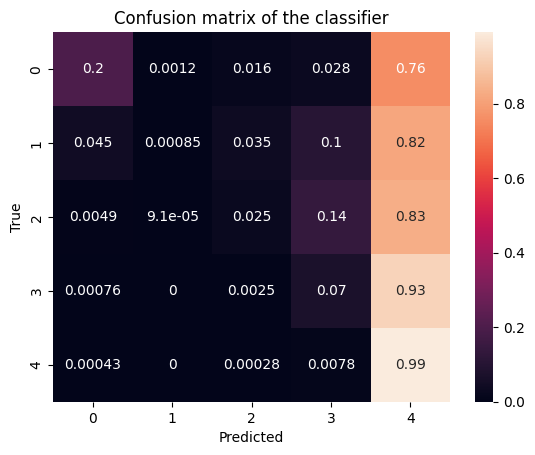

In [7]:
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create Submission File

In [8]:
# Combine text and numeric features for the submission set
X_submission_combined = scipy.sparse.hstack([X_submission_scaled, X_submission_text], format='csr')

# Now predict using the combined submission feature set
X_submission['Score'] = model.predict(X_submission_combined)

# Create and save the submission file
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    2.2s finished
